# 주식가격 예측 데이터 분석

## 데이터 불러오기

In [204]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import seaborn as sns

In [205]:
os.getcwd()

'C:\\Users\\KGH'

In [206]:
path = 'C:/Users/KGH/Desktop/data/프로젝트주식예측/'
list_name = 'stock_list.csv'
stock_list = pd.read_csv(os.path.join(path,list_name), encoding="cp949")
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list.head()

,종목명,종목코드,상장시장
0,삼양홀딩스,000070,KOSPI
1,하이트진로,000080,KOSPI
2,유한양행,000100,KOSPI
3,CJ대한통운,000120,KOSPI
4,두산,000150,KOSPI


In [4]:
#sample_submission 불러오기
list_name = 'sample_submission1.csv'
submission = pd.read_csv(os.path.join(path,list_name))

#column의 numeric을 종목코드로 변환
new_list=[]
for i in list(submission.columns[1:]):
    new_list.append(i.zfill(6))
new_list.insert(0,'Day')
submission.columns=new_list
submission.head()

,Day,000070,000080,000100,000120,000150,000210,000240,000270,000660,...,268600,272290,278280,290510,290650,293490,294140,298380,323990,357780
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA 
#### 0. 주식 데이터는 상하한선이 정해져있으므로 따로 이상치에 대해 처리하지 않을것이다.
#### 1. 일별 데이터보다는 주별 데이터가 추세를 파악하기엔 더 용이하지 않을까?
#### 2. 데이터의 길이(기간)는 어느정도가 좋을까? --> 이는 모델링에서 확인해보자
#### 3. 기술적 지표 외에 외부지표(ex. 다우지수 나스닥 등)도 영향을 줄까?
#### 4. 주식은 계절성을 가지고 있는데 이를 활용할수 없을까?
#### 5. 주식은 요일마다 경향성을 가지고 있지 않을까?
#### 6. 주식은 모두 테마를 가지고 있는데 같은 테마의 주식끼리는 비슷한 경향성을 가지지 않을까?

### 0

In [6]:
# 상장기간이 21년 이후인 종목 찾기
start_date = '20210104'
end_date = '20211105'
for i in stock_list['종목코드']:
    try:
        fdr.DataReader(i, start_date,start_date).iloc[0,0]
    except:
        print(stock_list[stock_list['종목코드']==i].iloc[0,0])

SK바이오사이언스
DL이앤씨
LX홀딩스


In [7]:
#각각 21년 11월, 21년 3월 상장 21년 5월 상장
stock_list=stock_list.drop(stock_list.loc[stock_list['종목명']=='DL이앤씨',].index) 
stock_list=stock_list.drop(stock_list.loc[stock_list['종목명']=='SK바이오사이언스',].index)
stock_list=stock_list.drop(stock_list.loc[stock_list['종목명']=='LX홀딩스',].index)

In [8]:
#21년도에 합병 혹은 상장폐지된 주식들 제거(찾는 코드는 지웠음)
stock_list=stock_list.drop(stock_list.loc[stock_list['종목코드']=='028150',].index) 
stock_list=stock_list.drop(stock_list.loc[stock_list['종목코드']=='031390',].index)
stock_list=stock_list.drop(stock_list.loc[stock_list['종목코드']=='036490',].index)

In [9]:
stock_list=stock_list.sort_values(by=['종목코드'],axis=0).reset_index(drop=True)

In [10]:
stock_list

,종목명,종목코드,상장시장
0,삼양홀딩스,000070,KOSPI
1,하이트진로,000080,KOSPI
2,유한양행,000100,KOSPI
3,CJ대한통운,000120,KOSPI
4,두산,000150,KOSPI
...,...,...,...
339,박셀바이오,323990,KOSDAQ
340,SK바이오팜,326030,KOSPI
341,두산퓨얼셀,336260,KOSPI
342,하이브,352820,KOSPI


In [11]:
sample_code = '000070'
max_weeknum = pd.to_datetime(end_date).strftime('%V')
print(f'총 몇주? : {max_weeknum}주')
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock.head() #데이터 형식 불러오기

총 몇주? : 44주


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,74400,74600,73100,73800,34561,-0.009396
2021-01-05,74000,74600,72800,74500,45447,0.009485
2021-01-06,74600,79200,73600,77100,97647,0.034899
2021-01-07,78000,79000,77700,78600,27677,0.019455
2021-01-08,77900,79100,77400,78300,35356,-0.003817


#### 데이터 내 6가지 변수: 시가 고가 저가 종가 거래량 전일대비 변동량

### 3
#### 다른 지표들이 코스피와 코스닥에 미치는 영향을 확인해보자

In [12]:
#나스닥 지수 추출
nasdaq=pdr.get_data_yahoo('^IXIC',start_date,end_date)
nasdaq.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,12958.719727,12543.240234,12958.519531,12698.450195,6546740000,12698.450195
2021-01-05,12828.269531,12665.650391,12665.650391,12818.959961,6904420000,12818.959961
2021-01-06,12909.629883,12649.990234,12666.150391,12740.790039,7648340000,12740.790039
2021-01-07,13090.910156,12867.339844,12867.339844,13067.480469,6777010000,13067.480469
2021-01-08,13208.089844,13036.549805,13160.219727,13201.980469,7223660000,13201.980469


In [13]:
#표준화 함수 만들어보기
def scale(x):
    return (x-np.mean(x))/np.std(x)

#### 변화율은 0.36의 상관관계를 가지고 있다. 요일에 따라서 영향력이 다를것으로 생각된다

#요일별로도 파악해보자
mon=pd.DataFrame()
tue=pd.DataFrame()
wed=pd.DataFrame()
thu=pd.DataFrame()
fri=pd.DataFrame()
for i in range(44):
    if i<43:
        i*=5
        wed=wed.append(daq1.iloc[i,])
        thu=thu.append(daq1.iloc[i+1,])
        fri=fri.append(daq1.iloc[i+2,])
        mon=mon.append(daq1.iloc[i+3,])
        tue=tue.append(daq1.iloc[i+4,])
    else:
        wed=wed.append(daq1.iloc[i,])
        thu=thu.append(daq1.iloc[i+1,])


# 계절별 변화율 변수 만들기
start_date = '20201201'
end_date = '20210301'
winter=[]
for i in stock_list['종목코드']:
    stock = fdr.DataReader(i, start = start_date, end = end_date)
    winter.append((stock.iloc[-1,3] / stock.iloc[0,3] ) - 1)
stock_list['Winter']=winter

start_date = '20210301'
end_date = '20210531'
spring=[]
for i in stock_list['종목코드']:
    stock = fdr.DataReader(i, start = start_date, end = end_date)
    spring.append((stock.iloc[-1,3] / stock.iloc[0,3] ) - 1)
stock_list['Spring']=spring

start_date = '20210601'
end_date = '20210831'
summer=[]
for i in stock_list['종목코드']:
    stock = fdr.DataReader(i, start = start_date, end = end_date)
    summer.append((stock.iloc[-1,3] / stock.iloc[0,3] ) - 1)
stock_list['Summer']=summer

start_date = '20200901'
end_date = '20201130'
autumn=[]
for i in stock_list['종목코드']:
    stock = fdr.DataReader(i, start = start_date, end = end_date)
    autumn.append((stock.iloc[-1,3] / stock.iloc[0,3] ) - 1)
stock_list['Autumn']=autumn

stock_list.head(10)

### 5
#### 요일별 추세 파악해보기

In [14]:
#공휴일이 없는 기간으로 설정
start_date = '20210104'
end_date = '20211031'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}') # start_date가 무슨 요일인지
print(f'HOW MANY "Business_days" : {Business_days.shape}', ) # 평일이 총 며칠인지

WEEKDAY of "start_date" : 0
HOW MANY "Business_days" : (215, 1)


In [15]:
sample = fdr.DataReader('005930', start = start_date, end = end_date)[['Close']].reset_index() # 종가를 이용
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample=sample.fillna(method='ffill')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
01,83000.0,83900.0,82200.0,82900.0,88800.0
02,91000.0,90600.0,89700.0,89700.0,88000.0
03,85000.0,87000.0,87200.0,88100.0,86800.0
04,89400.0,86700.0,85600.0,83700.0,82000.0
05,83000.0,84400.0,84600.0,82500.0,83500.0


#### 그래프가 너무 난잡하다.. 요일별 추세는 딱히 보이지 않는것 같다

#### 각 테마마다 유사한 경향성을 보이는것 같다

위 EDA를 통해 우리는 기존 데이터셋의 5가지 변수에 추가로 2가지 변수를 더 만들기로 했다
1. 코스닥 한정 전일 나스닥지수의 변화율
2. 주식별 테마

### 7
### 주식 섹터별 정리해보기
### 웹 크롤링해서  WICS 섹터지표 가져오기(21.07.15.기준)

In [16]:
pip install qconfig

Note: you may need to restart the kernel to use updated packages.


In [17]:
wics_lc = {10:'에너지', 
           15:'소재', 
           20:'산업재', 
           25:'경기관련소비재', 
           30:'필수소비재', 
           35:'건강관리',
           40:'금융', 
           45:'IT', 
           50:'커뮤니케이션서비스', 
           55:'유틸리티'}
 
wics_mc = {1010:'에너지',
           1510:'소재',
           2010:'자본재',
           2020:'상업서비스와공급품',
           2030:'운송',
           2510:'자동차와부품',
           2520:'내구소비재와의류',
           2530:'호텔,레스토랑,레저 등',
           2550:'소매(유통)',
           2560:'교육서비스',
           3010:'식품과기본식료품소매',
           3020:'식품,음료,담배',
           3030:'가정용품과개인용품',
           3510:'건강관리장비와서비스',
           3520:'제약과생물공학',
           4010:'은행',
           4020:'증권',
           4030:'다각화된금융',
           4040:'보험',
           4050:'부동산',
           4510:'소프트웨어와서비스',
           4520:'기술하드웨어와장비',
           4530:'반도체와반도체장비',
           4535:'전자와 전기제품',
           4540:'디스플레이',
           5010:'전기통신서비스',
           5020:'미디어와엔터테인먼트',
           5510:'유틸리티'}
 
def wics_url(date, wics_code):
    '''
    Parameter
    - date[str] : the date corresponding data (yyyymmdd)
    - wics_code[int] : the wics code corresponding data (use wics_lc or wics_mc)
    
    Return
    - url[str]
    '''
    url ='http://www.wiseindex.com/Index/GetIndexComponets?ceil_yn=0&'\
          'dt=' + date + '&sec_cd=G' + str(wics_code)
    return url
 
def comp_url(code):
    '''
    Parameter
    - code[str] : the company code corresponding data
    
    Return
    - url[str]
    '''
    url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&'\
          'gicode=A' + code + \
          '&cID=&MenuYn=Y&ReportGB=&NewMenuID=Y&stkGb=701'
    return url

In [24]:
import requests
from pandas import DataFrame
 
if __name__=='__main__':
    wics = DataFrame(columns=['code', 'name', 'ls', 'ms'])
    date = '20211001'
    # there is no data in the stock market closed day and before market open. 
    # weekends, Jan 1, Dec 31 etc
    
    for wics_code in wics_mc.keys():
        response = requests.get(wics_url(date, wics_code))
    
        if(response.status_code == 200): # request success
            json_list = response.json() # dictionary
            # response.text -> return str type
            for json in json_list['list']:
                ls = json['SEC_NM_KOR'] # Large sector
                ms = json['IDX_NM_KOR'][5:] # Medium sector
                code = json['CMP_CD'] # Company code
                name = json['CMP_KOR'] # Company korean name
                wics = wics.append({'code':code, 'name':name, 'ls':ls, 'ms':ms}, 
                          ignore_index=True)
        else:
            print('Error:' + response.status_code)
            print('WICS code:' + str(wics_code))

In [25]:
wics.head()

,code,name,ls,ms
0,096770,SK이노베이션,에너지,에너지
1,010950,S-Oil,에너지,에너지
2,267250,현대중공업지주,에너지,에너지
3,078930,GS,에너지,에너지
4,006120,SK디스커버리,에너지,에너지


In [26]:
wics = wics[wics.iloc[:,0].isin(stock_list['종목코드'])]
wics=wics.sort_values(by=['code'], axis=0)
wics.head(10)

,code,name,ls,ms
966,000070,삼양홀딩스,필수소비재,"식품,음료,담배"
959,000080,하이트진로,필수소비재,"식품,음료,담배"
1133,000100,유한양행,건강관리,제약과생물공학
570,000120,CJ대한통운,산업재,운송
298,000150,두산,산업재,자본재
277,000210,DL,산업재,자본재
622,000240,한국앤컴퍼니,경기관련소비재,자동차와부품
1165,000250,삼천당제약,건강관리,제약과생물공학
608,000270,기아,경기관련소비재,자동차와부품
1805,000660,SK하이닉스,IT,반도체와반도체장비


In [27]:
stock_list['big']=list(wics.ls)
stock_list['small']=list(wics.ms)
stock_list.head()

,종목명,종목코드,상장시장,big,small
0,삼양홀딩스,000070,KOSPI,필수소비재,"식품,음료,담배"
1,하이트진로,000080,KOSPI,필수소비재,"식품,음료,담배"
2,유한양행,000100,KOSPI,건강관리,제약과생물공학
3,CJ대한통운,000120,KOSPI,산업재,운송
4,두산,000150,KOSPI,산업재,자본재


# Time series k-means clustering 해보기

In [28]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [26]:
#3차원 배열구성은 (기준값*시간*특성)이며 우리의 데이터로는 (주식*일수*종가)로 표시된다

In [38]:
#모델에 넣을 데이터프레임 제작
def make_df(one_sector):
    b = np.empty((0,1), int)
    for j in one_sector['종목코드']:
        stock = fdr.DataReader(j, start = start_date, end = end_date)
        a = np.array(scale(stock.Close))
        b = np.append(b,a)
    
    b = b.reshape( len(one_sector['종목코드']), len(a), 1)
    return (b)

def clustering(b, n):
    km = TimeSeriesKMeans(n_clusters=n, 
              metric="dtw", 
              max_iter=5,
              random_state=42)
    prediction = km.fit_predict(b)
    return [prediction, km]

In [39]:
big_list=['금융','건강관리','산업재','경기관련소비재','IT','소재','커뮤니케이션서비스']

big 분류:  금융
[6, 10, 16, 17, 19, 20, 21, 22]


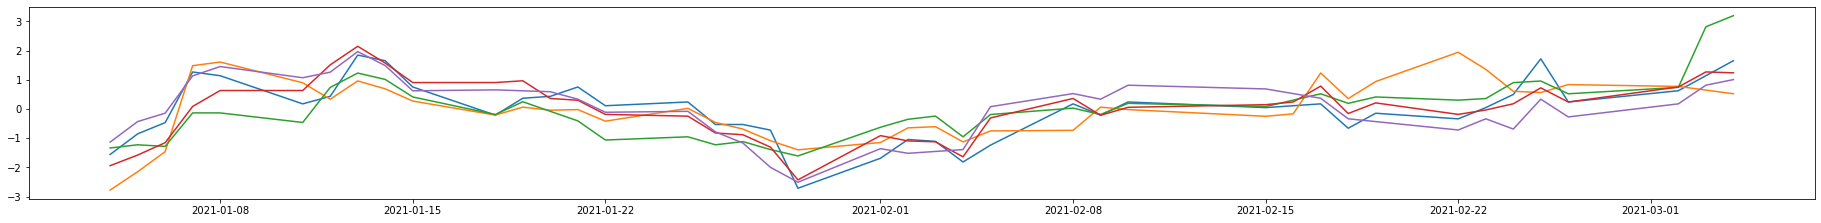

[1, 4, 5, 7, 9, 11, 13, 14, 18]


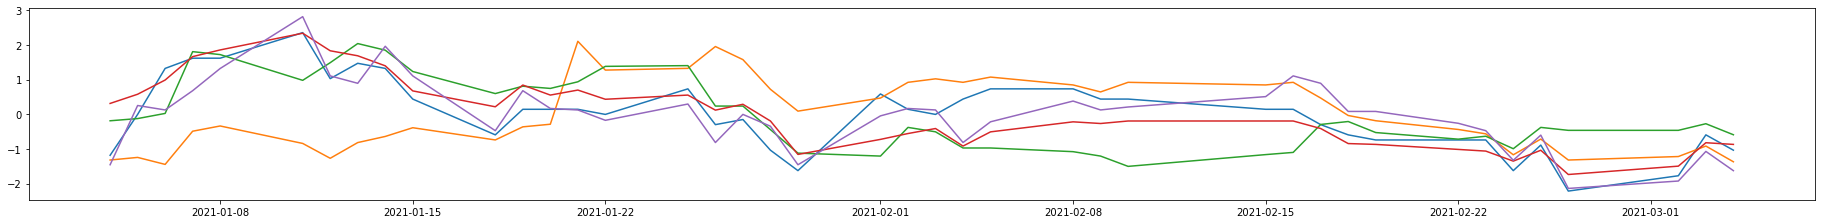

[0, 2, 3, 8, 12, 15, 23]


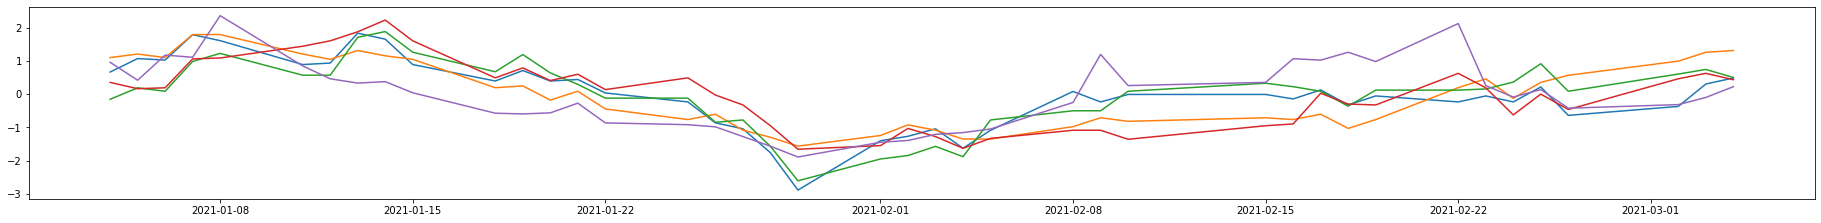

big 분류:  건강관리
[6, 11, 18, 24, 28, 35, 38, 39, 43, 45, 46, 50, 51, 52]


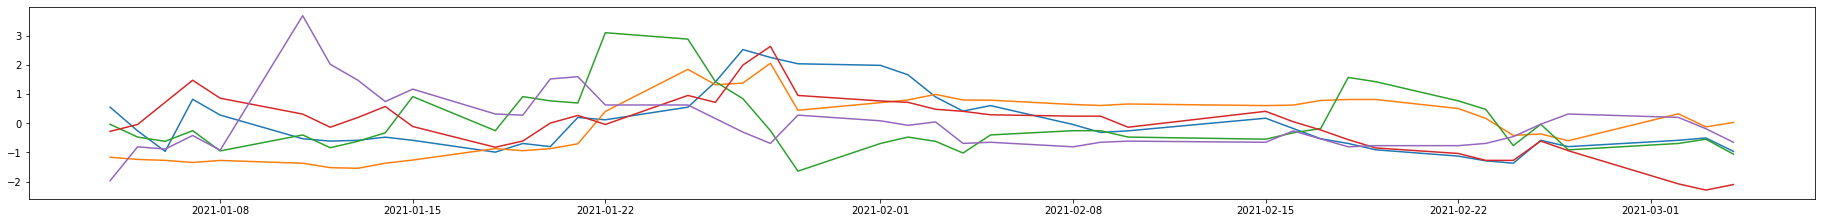

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 32, 33, 34, 36, 37, 40, 41, 42, 44, 47, 48, 49, 53, 54, 55]


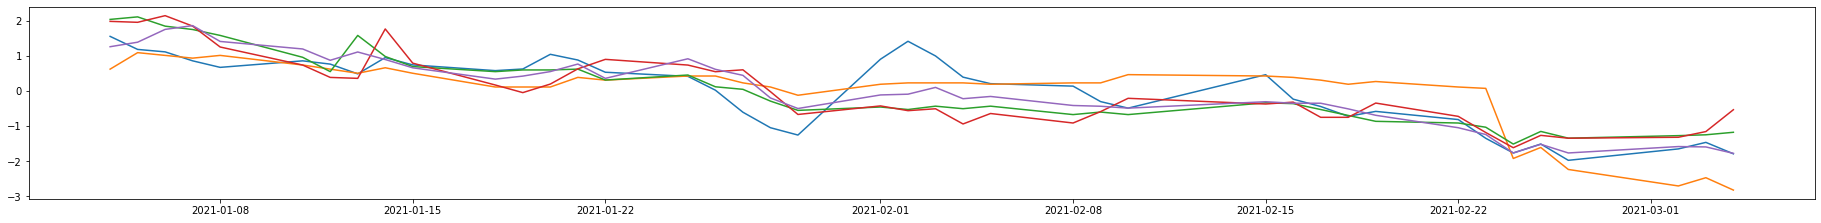

[16, 29]


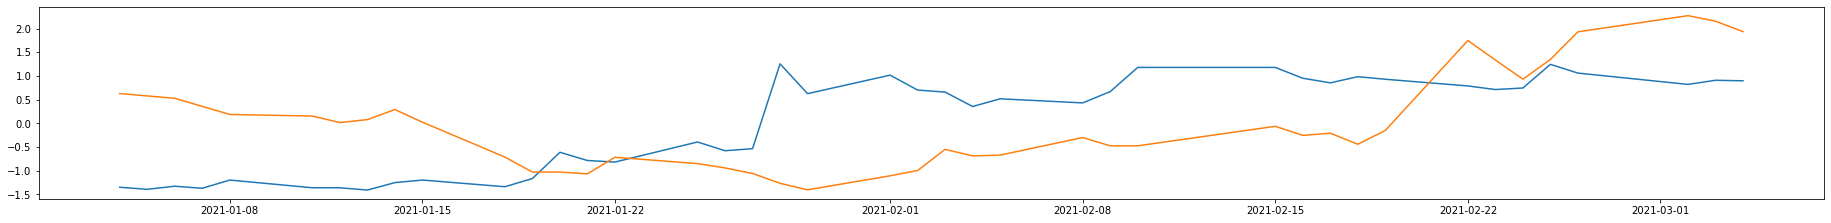

big 분류:  산업재
[0, 1, 3, 4, 8, 9, 10, 11, 12, 14, 20, 22, 23, 26, 30, 38, 41, 42, 44, 46, 48, 49, 51, 54, 56]


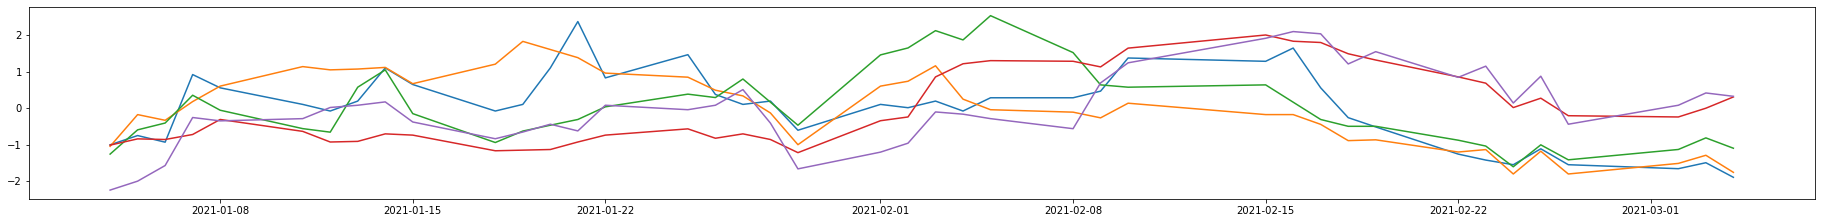

[6, 13, 15, 16, 17, 18, 24, 25, 27, 28, 29, 31, 32, 33, 35, 36, 37, 40, 47, 50, 52, 53]


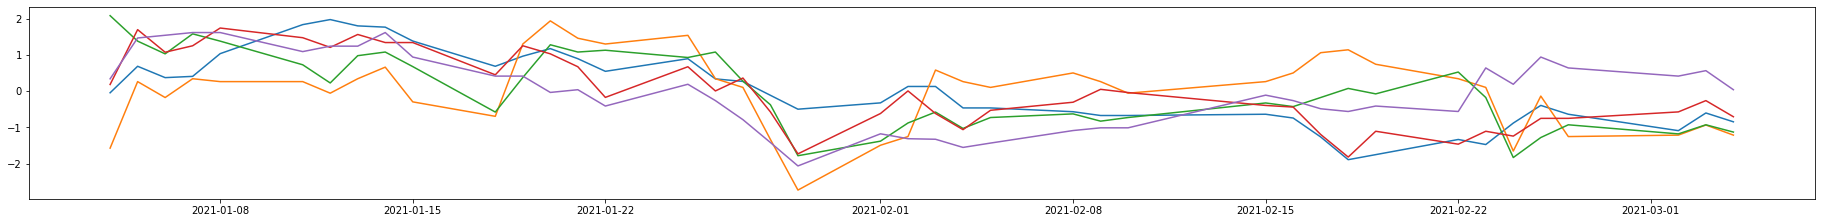

[2, 5, 7, 19, 21, 34, 39, 43, 45, 55]


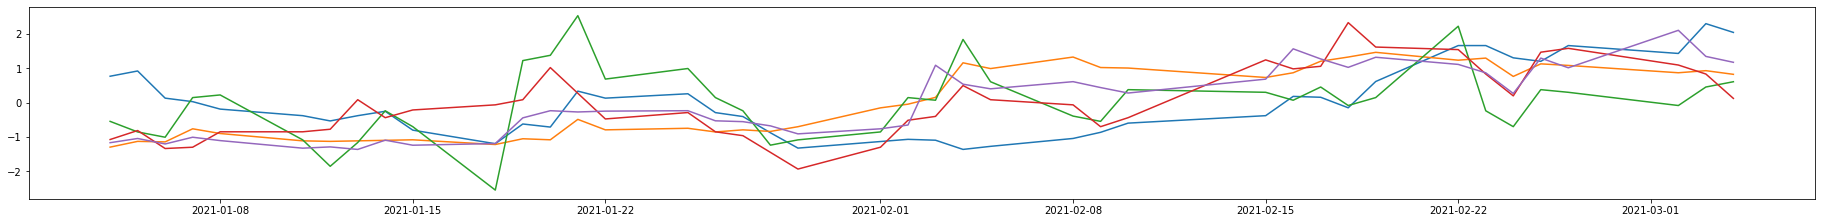

big 분류:  경기관련소비재
[0, 1, 3, 5, 12, 14, 22, 25, 29, 31, 32, 34, 38, 40, 48, 51]


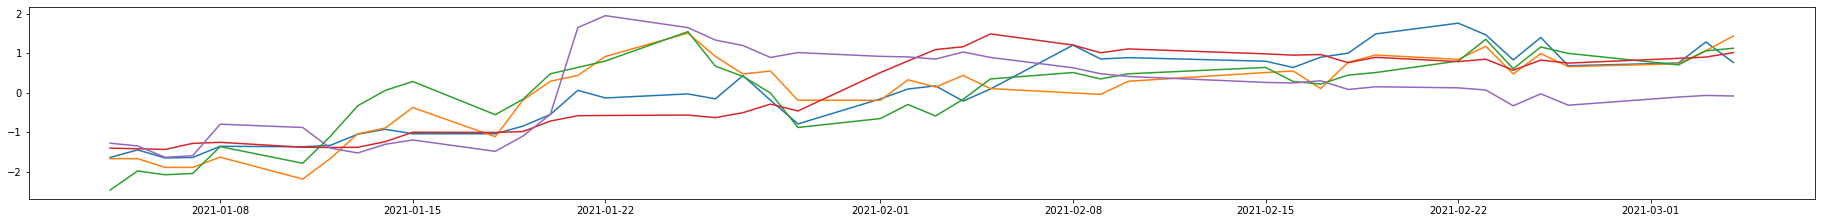

[6, 8, 11, 13, 15, 17, 19, 27, 28, 33, 37, 42, 45, 49]


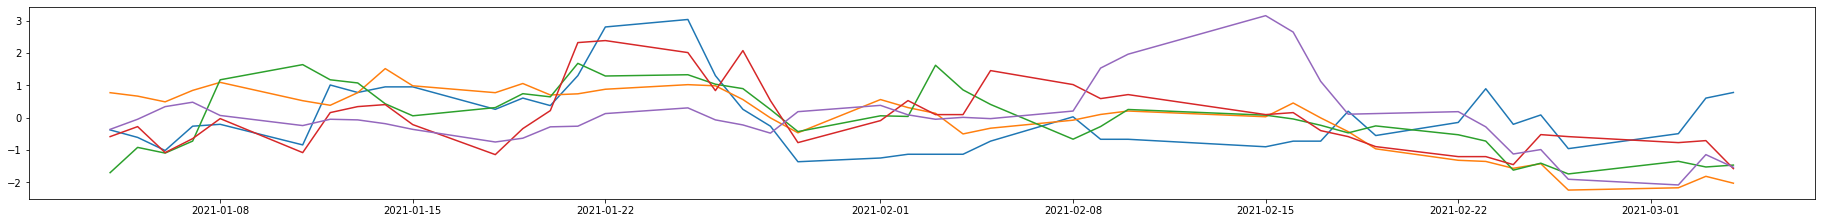

[2, 4, 7, 9, 10, 16, 18, 20, 21, 23, 24, 26, 30, 35, 36, 39, 41, 43, 44, 46, 47, 50]


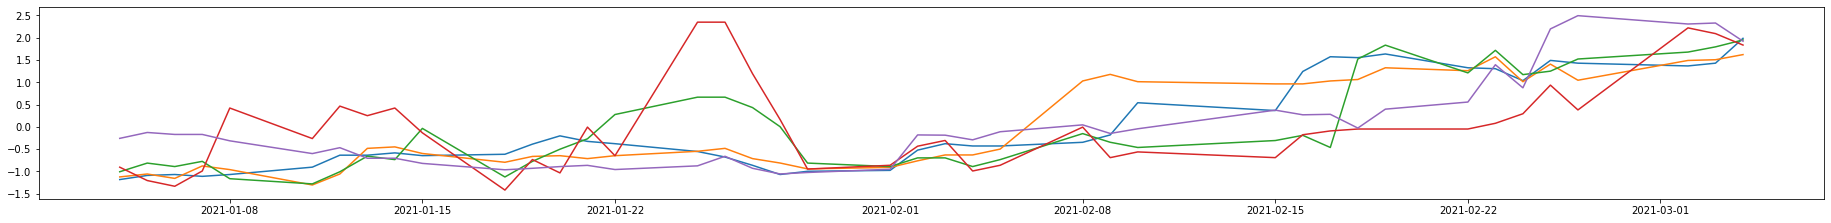

big 분류:  IT
[3, 8, 10, 12, 15, 20, 22, 23, 26, 28, 32, 33, 34, 35, 37, 38, 40, 42, 46, 49, 51, 52, 54, 57, 58, 59, 60, 62, 66, 69]


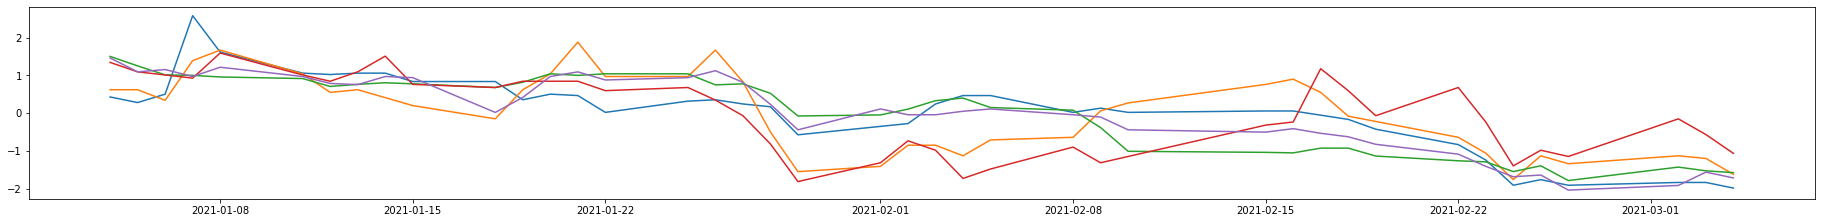

[2, 4, 5, 6, 7, 9, 11, 13, 14, 17, 18, 19, 21, 25, 30, 31, 39, 41, 44, 45, 47, 48, 50, 53, 63, 64, 65, 68, 70]


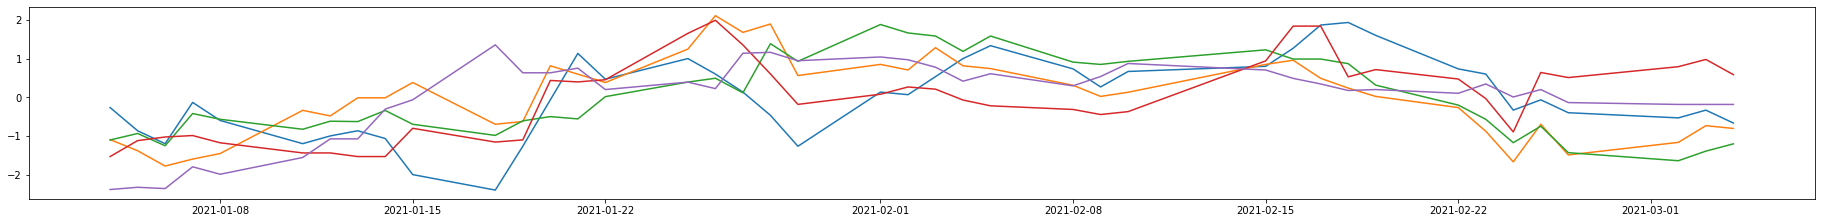

[0, 1, 16, 24, 27, 29, 36, 43, 55, 56, 61, 67, 71]


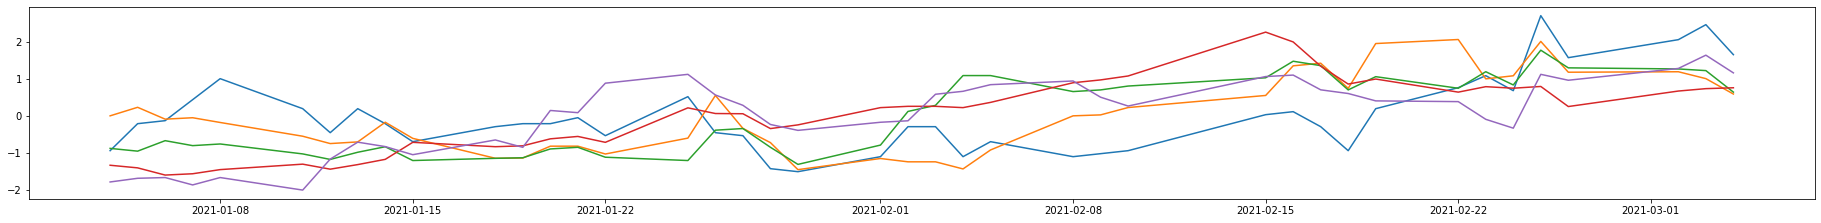

big 분류:  소재
[0, 1, 2, 5, 6, 8, 10, 11, 12, 13, 14, 19, 23, 25, 26, 27, 30]


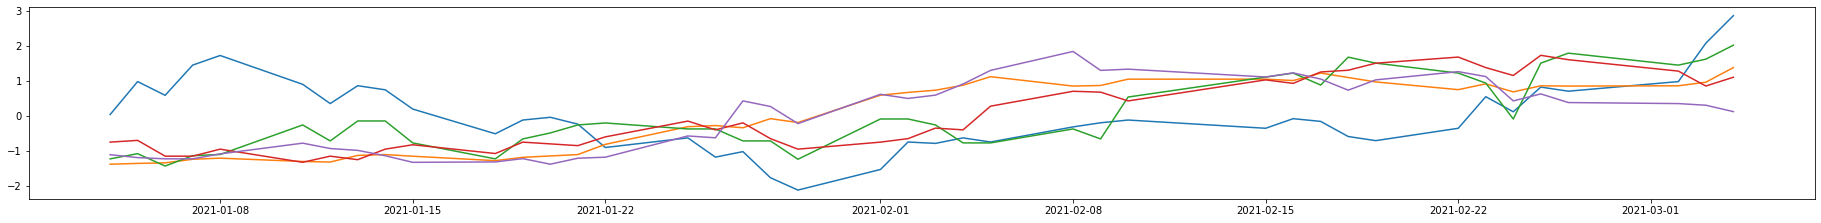

[3, 4, 15, 17, 18, 20, 21, 22, 24, 28, 29]


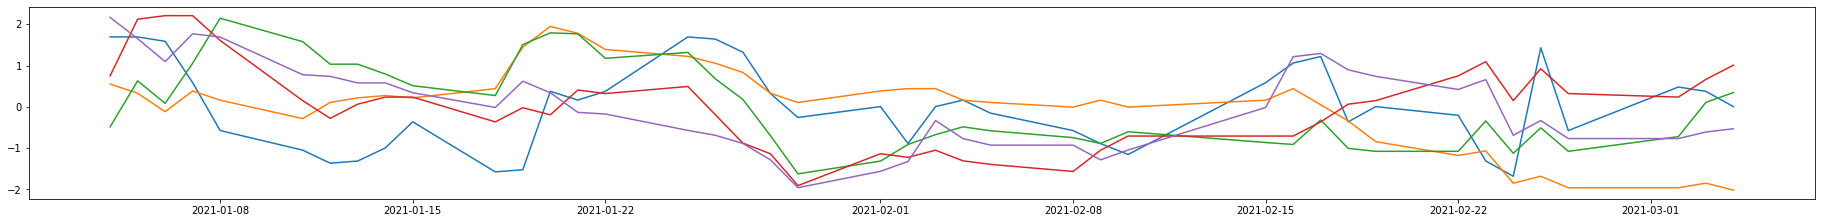

[7, 9, 16]


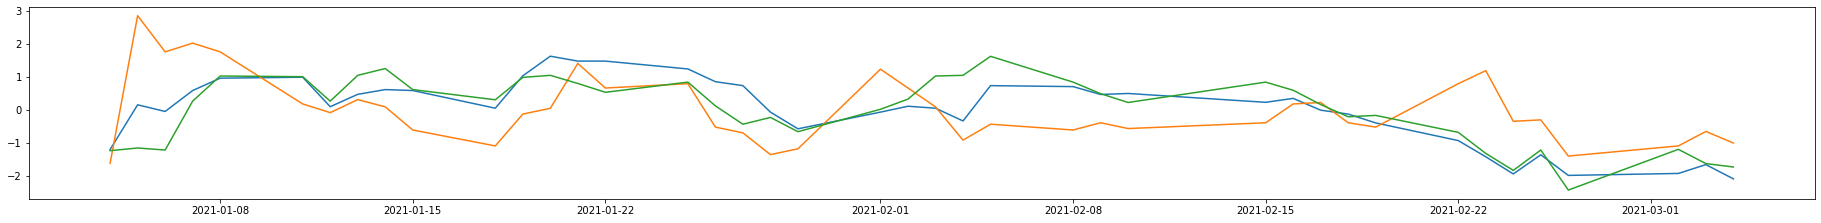

big 분류:  커뮤니케이션서비스
[0, 1, 3, 6, 7, 8, 11, 12, 16, 18, 19, 20, 21]


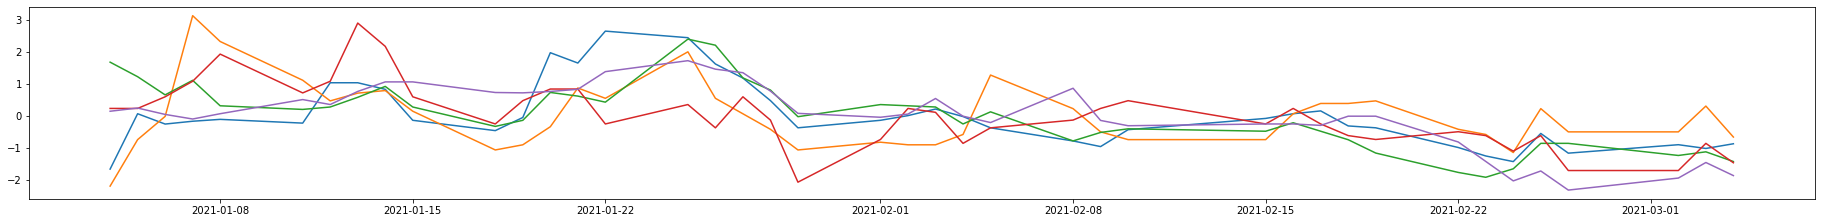

[2, 4, 5, 10, 17, 23, 24]


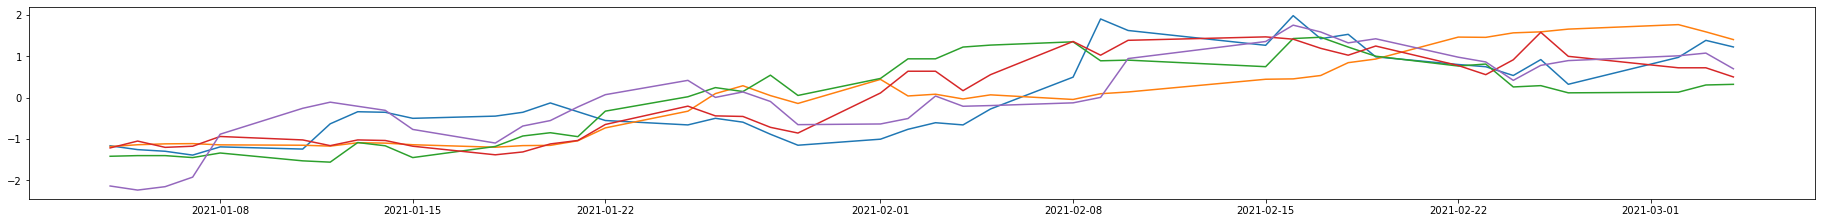

[9, 13, 14, 15, 22]


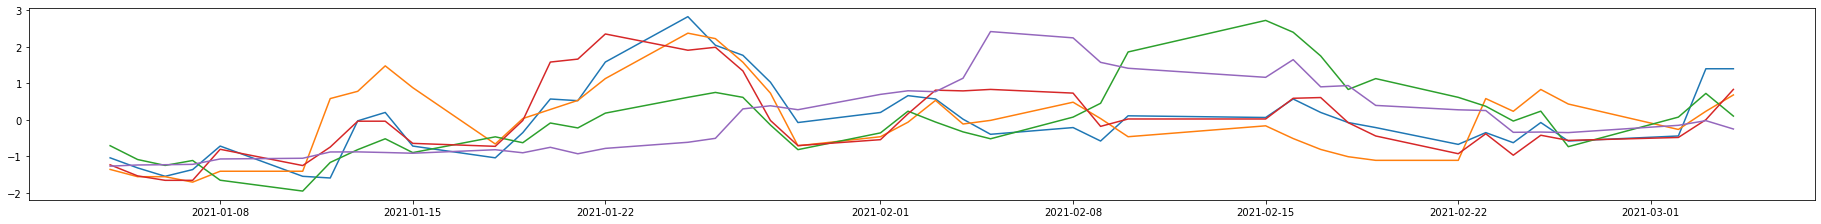

In [40]:
start_date = '20210104'
end_date = '20210304'
import random
for i in big_list:
    print("big 분류: ", i)
    one_sector=stock_list[stock_list['big']==i]
    #모델에 넣을 데이터프레임 제작 함수
    b = make_df(one_sector)
        
    #시계열 클러스터 3개 만들기
    cluster = clustering(b, 3)
    prediction = cluster[0]
    km = cluster[1]
        
    #한 섹터 안 클러스터 1,2,3 돌리는 for문 시작
    for target in range(0,3):
        plt.figure(figsize=(32,12))
        plt.subplot(3,1,target+1)
        cluster_list = list(filter(lambda x: list(prediction)[x] == target, range(len(list(prediction)))))
        #원래의 stock_list에 분류한 군집 정보 넣어주기
        for index in cluster_list:
            stock_list.loc[ stock_list['종목코드'] == one_sector.iloc[index,1], 'Cluster'] = str(i)+'그룹'+str(target)
        #플롯 그리기 전 많으면 다섯개만 뽑기.
        print(cluster_list)
        if len(cluster_list)>5:
            cluster_list = random.sample(cluster_list,5)
        for index in cluster_list:
            stock = fdr.DataReader(one_sector.iloc[index,1], start_date, end_date)
            plt.plot(scale(stock.Close))
        #한 클러스터 끝날 때 마다 그래프 보여주기
        plt.show()

In [33]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)

In [41]:
stock_list

,종목명,종목코드,상장시장,big,small,Cluster
0,삼양홀딩스,000070,KOSPI,필수소비재,"식품,음료,담배",NaN
1,하이트진로,000080,KOSPI,필수소비재,"식품,음료,담배",NaN
2,유한양행,000100,KOSPI,건강관리,제약과생물공학,건강관리그룹1
3,CJ대한통운,000120,KOSPI,산업재,운송,산업재그룹0
4,두산,000150,KOSPI,산업재,자본재,산업재그룹0
5,DL,000210,KOSPI,산업재,자본재,산업재그룹2
6,한국앤컴퍼니,000240,KOSPI,경기관련소비재,자동차와부품,경기관련소비재그룹0
7,삼천당제약,000250,KOSDAQ,건강관리,제약과생물공학,건강관리그룹1
8,기아,000270,KOSPI,경기관련소비재,자동차와부품,경기관련소비재그룹0
9,SK하이닉스,000660,KOSPI,IT,반도체와반도체장비,IT그룹2


In [42]:
stock_list["Cluster"].value_counts()

건강관리그룹1         40
IT그룹0           30
IT그룹1           29
산업재그룹0          25
산업재그룹1          22
경기관련소비재그룹2      22
소재그룹0           17
경기관련소비재그룹0      16
경기관련소비재그룹1      14
건강관리그룹0         14
커뮤니케이션서비스그룹0    13
IT그룹2           13
소재그룹1           11
산업재그룹2          10
금융그룹1            9
금융그룹0            8
커뮤니케이션서비스그룹1     7
금융그룹2            7
커뮤니케이션서비스그룹2     5
소재그룹2            3
건강관리그룹2          2
Name: Cluster, dtype: int64

In [74]:
stock_list[stock_list["big"]=="필수소비재"]

,종목명,종목코드,상장시장,big,small,Cluster
0,삼양홀딩스,000070,KOSPI,필수소비재,"식품,음료,담배",NaN
1,하이트진로,000080,KOSPI,필수소비재,"식품,음료,담배",NaN
21,대상,001680,KOSPI,필수소비재,"식품,음료,담배",NaN
23,오리온홀딩스,001800,KOSPI,필수소비재,"식품,음료,담배",NaN
29,삼양식품,003230,KOSPI,필수소비재,"식품,음료,담배",NaN
31,하림지주,003380,KOSDAQ,필수소비재,"식품,음료,담배",NaN
41,농심,004370,KOSPI,필수소비재,"식품,음료,담배",NaN
44,롯데지주,004990,KOSPI,필수소비재,"식품,음료,담배",NaN
47,롯데칠성,005300,KOSPI,필수소비재,"식품,음료,담배",NaN
54,동원산업,006040,KOSPI,필수소비재,"식품,음료,담배",NaN


In [80]:
sobi_list=stock_list[stock_list["big"]=="필수소비재"].index

In [81]:
for i in sobi_list:
    stock_list["Cluster"][i]="필수소비재"

In [82]:
stock_list[stock_list["big"]=="필수소비재"]

,종목명,종목코드,상장시장,big,small,Cluster
0,삼양홀딩스,000070,KOSPI,필수소비재,"식품,음료,담배",필수소비재
1,하이트진로,000080,KOSPI,필수소비재,"식품,음료,담배",필수소비재
21,대상,001680,KOSPI,필수소비재,"식품,음료,담배",필수소비재
23,오리온홀딩스,001800,KOSPI,필수소비재,"식품,음료,담배",필수소비재
29,삼양식품,003230,KOSPI,필수소비재,"식품,음료,담배",필수소비재
31,하림지주,003380,KOSDAQ,필수소비재,"식품,음료,담배",필수소비재
41,농심,004370,KOSPI,필수소비재,"식품,음료,담배",필수소비재
44,롯데지주,004990,KOSPI,필수소비재,"식품,음료,담배",필수소비재
47,롯데칠성,005300,KOSPI,필수소비재,"식품,음료,담배",필수소비재
54,동원산업,006040,KOSPI,필수소비재,"식품,음료,담배",필수소비재


In [84]:
stock_list[stock_list["big"]=="에너지"]

,종목명,종목코드,상장시장,big,small,Cluster
55,SK디스커버리,006120,KOSPI,에너지,에너지,NaN
82,S-Oil,010950,KOSPI,에너지,에너지,NaN
212,GS,078930,KOSPI,에너지,에너지,NaN
240,SK이노베이션,096770,KOSPI,에너지,에너지,NaN
320,현대중공업지주,267250,KOSPI,에너지,에너지,NaN


In [87]:
energy_list=stock_list[stock_list["big"]=="에너지"].index

In [88]:
for i in energy_list:
    stock_list["Cluster"][i]="에너지"

In [89]:
stock_list[stock_list["big"]=="에너지"]

,종목명,종목코드,상장시장,big,small,Cluster
55,SK디스커버리,006120,KOSPI,에너지,에너지,에너지
82,S-Oil,010950,KOSPI,에너지,에너지,에너지
212,GS,078930,KOSPI,에너지,에너지,에너지
240,SK이노베이션,096770,KOSPI,에너지,에너지,에너지
320,현대중공업지주,267250,KOSPI,에너지,에너지,에너지


In [91]:
stock_list[stock_list["big"]=="유틸리티"]

,종목명,종목코드,상장시장,big,small,Cluster
97,한국전력,015760,KOSPI,유틸리티,유틸리티,NaN
147,한국가스공사,036460,KOSPI,유틸리티,유틸리티,NaN
174,한전KPS,051600,KOSPI,유틸리티,유틸리티,NaN
177,한전기술,052690,KOSPI,유틸리티,유틸리티,NaN


In [92]:
utility_list=stock_list[stock_list["big"]=="유틸리티"].index

In [93]:
for i in utility_list:
    stock_list["Cluster"][i]="유틸리티"

In [94]:
stock_list[stock_list["big"]=="유틸리티"]

,종목명,종목코드,상장시장,big,small,Cluster
97,한국전력,015760,KOSPI,유틸리티,유틸리티,유틸리티
147,한국가스공사,036460,KOSPI,유틸리티,유틸리티,유틸리티
174,한전KPS,051600,KOSPI,유틸리티,유틸리티,유틸리티
177,한전기술,052690,KOSPI,유틸리티,유틸리티,유틸리티


In [98]:
stock_list["Cluster"].isna().sum()

0

# 모델링

# LGBM

In [100]:
import pandas as pd
import numpy as np
import datetime
import FinanceDataReader as fdr
import requests as req
import lightgbm as lgb
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn import metrics
import os
import sys
import random
import warnings

warnings.filterwarnings(action='ignore')

# 기간 20210104~20211126

In [114]:
# 주가 데이타 추출 일자  
start_date = '20210104'   
end_date   = '20211126'   

In [163]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [164]:
def feature_engineering(df, days = 100) :
    use_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
    
    df = df.ffill()
    
    # use_features * days * row
    for col in use_features:
      for lag in range(1,days+1) :
        df[f'{col}_day_{lag}'] = -1
        for index in range(lag, len(df)) :
          df.loc[index, f'{col}_day_{lag}'] = df[col][index-lag] # 1~days전 가격을 feature로 추가
    

    for day in ['after_1', 'after_2', 'after_3', 'after_4', 'after_5'] :
      df[day] = 0
      n_day = int(day[-1])
      for index in range(len(df)) :
        try : df[day][index] = df['Close'][index + n_day]
        except : continue
    
    return df

In [165]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date).reset_index()
sample.head()

,Date,Open,High,Low,Close,Volume,Change
0,2021-10-05,106000,110000,105000,106500,46907,-0.009302
1,2021-10-06,109500,109500,102500,104000,49148,-0.023474
2,2021-10-07,105500,110000,105500,109000,40767,0.048077
3,2021-10-08,109000,110000,106500,106500,30455,-0.022936
4,2021-10-12,105500,106000,103000,104500,18488,-0.018779


In [121]:
stock_list

,종목명,종목코드,상장시장,big,small,Cluster
0,삼양홀딩스,000070,KOSPI,필수소비재,"식품,음료,담배",필수소비재
1,하이트진로,000080,KOSPI,필수소비재,"식품,음료,담배",필수소비재
2,유한양행,000100,KOSPI,건강관리,제약과생물공학,건강관리그룹1
3,CJ대한통운,000120,KOSPI,산업재,운송,산업재그룹0
4,두산,000150,KOSPI,산업재,자본재,산업재그룹0
5,DL,000210,KOSPI,산업재,자본재,산업재그룹2
6,한국앤컴퍼니,000240,KOSPI,경기관련소비재,자동차와부품,경기관련소비재그룹0
7,삼천당제약,000250,KOSDAQ,건강관리,제약과생물공학,건강관리그룹1
8,기아,000270,KOSPI,경기관련소비재,자동차와부품,경기관련소비재그룹0
9,SK하이닉스,000660,KOSPI,IT,반도체와반도체장비,IT그룹2


In [166]:
sample["Cluster"]=stock_list["Cluster"]
sample

,Date,Open,High,Low,Close,Volume,Change,Cluster
0,2021-10-05,106000,110000,105000,106500,46907,-0.009302,필수소비재
1,2021-10-06,109500,109500,102500,104000,49148,-0.023474,필수소비재
2,2021-10-07,105500,110000,105500,109000,40767,0.048077,건강관리그룹1
3,2021-10-08,109000,110000,106500,106500,30455,-0.022936,산업재그룹0
4,2021-10-12,105500,106000,103000,104500,18488,-0.018779,산업재그룹0
5,2021-10-13,104000,107500,102500,105500,27391,0.009569,산업재그룹2
6,2021-10-14,106500,111000,106500,109500,31177,0.037915,경기관련소비재그룹0
7,2021-10-15,110000,112500,108500,111000,24471,0.013699,건강관리그룹1
8,2021-10-18,111000,111000,108000,108500,21685,-0.022523,경기관련소비재그룹0
9,2021-10-19,110500,112000,108500,110500,18233,0.018433,IT그룹2


In [131]:
test = feature_engineering(sample)

In [133]:
test.head()

,Date,Open,High,Low,Close,Volume,Change,Cluster,Open_day_1,Open_day_2,...,Change_day_96,Change_day_97,Change_day_98,Change_day_99,Change_day_100,after_1,after_2,after_3,after_4,after_5
0,2021-01-04,74400,74600,73100,73800,34561,-0.009396,필수소비재,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,74500,77100,78600,78300,76200
1,2021-01-05,74000,74600,72800,74500,45447,0.009485,필수소비재,74400,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,77100,78600,78300,76200,76300
2,2021-01-06,74600,79200,73600,77100,97647,0.034899,건강관리그룹1,74000,74400,...,-1.0,-1.0,-1.0,-1.0,-1.0,78600,78300,76200,76300,77000
3,2021-01-07,78000,79000,77700,78600,27677,0.019455,산업재그룹0,74600,74000,...,-1.0,-1.0,-1.0,-1.0,-1.0,78300,76200,76300,77000,80300
4,2021-01-08,77900,79100,77400,78300,35356,-0.003817,산업재그룹0,78000,74600,...,-1.0,-1.0,-1.0,-1.0,-1.0,76200,76300,77000,80300,81100


In [ ]:
submission

In [109]:
import lightgbm

# 11월 1일 ~ 11월 5일 주식 종가 예측

In [136]:
model = lightgbm.LGBMRegressor(random_state=13)

days = 100
label_columns = ['after_1', 'after_2', 'after_3', 'after_4', 'after_5', ]
predict_days = 5 * -1 

accuracy = []
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    data = feature_engineering(data)
    data = data[:-15]

    final_x = data.iloc[-1:]
    final_x = final_x.drop(['Date'] + label_columns, axis=1)
    
    x_val = data.iloc[-6:-5]
    x_val = x_val.drop(['Date'] + label_columns, axis=1)
    
    y_val = data.Close[predict_days:]

    # 이전 day 값이 없는 row 제외, 예측하는 날의 row 제외.
    train = data.drop(['Date'], axis=1)[days:predict_days]

    # after 1~5 columns 제외.
    x_train = train.drop(label_columns, axis=1)

    predictions = []
    final_predictions = []
    answers = []
    # 1일 후 부터 5일 후 까지 각각 예측.
    for j in range(1, 6):
        y_train = train[f'after_{j}']
        try:
            model.fit(x_train, y_train)
        except:
            print(f'code:{code}')

        output = model.predict(x_val)
        predictions.append(output[0])

        final_output = model.predict(final_x)
        final_predictions.append(final_output[0])
        
    accuracy.append(NMAE(predictions, y_val))
    submission.loc[:4,code] = predictions 
print(f'na:{submission.isna().sum().sum()}')
print(f'acc:{sum(accuracy)/len(accuracy)}')

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [3:16:51<00:00, 34.34s/it]

na:5
acc:0.006348631595464041


In [138]:
submission['000070']

0    105871.525893
1    104189.939119
2    104966.386619
3    105274.189247
4    105385.160924
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
Name: 000070, dtype: float64

# 11월 29일 ~ 12월 3일 주식 종가 예측

In [ ]:
model = lightgbm.LGBMRegressor(random_state=13)

days = 5
label_columns = ['after_1', 'after_2', 'after_3', 'after_4', 'after_5', ]
predict_days = 5 * -1 

accuracy = []
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    data = feature_engineering(data)
    
    final_x = data.iloc[-1:]
    final_x = final_x.drop(['Date'] + label_columns, axis=1)
    # print(final_x);break
    x_val = data.iloc[-6:-5]
    x_val = x_val.drop(['Date'] + label_columns, axis=1)
    
    y_val = data.Close[predict_days:]

    # 이전 day 값이 없는 row 제외, 예측하는 날의 row 제외.
    train = data.drop(['Date'], axis=1)[days:predict_days]

    # after 1~5 columns 제외.
    x_train = train.drop(label_columns, axis=1)

    predictions = []
    final_predictions = []
    answers = []
    # 1일 후 부터 5일 후 까지 각각 예측.
    for j in range(1, 6):
        y_train = train[f'after_{j}']
        try:
            model.fit(x_train, y_train)
        except:
            print(f'code:{code}')

        output = model.predict(x_val)
        predictions.append(output[0])

        final_output = model.predict(final_x)
        final_predictions.append(final_output[0])
        
    accuracy.append(NMAE(predictions, y_val))
    submission.loc[5:,code] = predictions
print(f'na:{submission.isna().sum().sum()}')
print(f'acc:{sum(accuracy)/len(accuracy)}')

In [ ]:
submission['000070']

In [ ]:
columns = list(submission.columns[1:])

columns = ['Day'] + [str(x).zfill(6) for x in columns]

submission.columns = columns

In [ ]:
submission.to_csv('one_year_last.csv',index=False)

# 기간 20211004~20211126

In [170]:
# 주가 데이타 추출 일자  
start_date = '20211004'   
end_date   = '20211126'   

In [171]:
#sample_submission 불러오기
list_name = 'sample_submission1.csv'
submission = pd.read_csv(os.path.join(path,list_name))

#column의 numeric을 종목코드로 변환
new_list=[]
for i in list(submission.columns[1:]):
    new_list.append(i.zfill(6))
new_list.insert(0,'Day')
submission.columns=new_list
submission.head()

,Day,000070,000080,000100,000120,000150,000210,000240,000270,000660,...,268600,272290,278280,290510,290650,293490,294140,298380,323990,357780
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date).reset_index()
sample.head()

,Date,Open,High,Low,Close,Volume,Change
0,2021-10-05,106000,110000,105000,106500,46907,-0.009302
1,2021-10-06,109500,109500,102500,104000,49148,-0.023474
2,2021-10-07,105500,110000,105500,109000,40767,0.048077
3,2021-10-08,109000,110000,106500,106500,30455,-0.022936
4,2021-10-12,105500,106000,103000,104500,18488,-0.018779


In [173]:
sample["Cluster"]=stock_list["Cluster"]
sample

,Date,Open,High,Low,Close,Volume,Change,Cluster
0,2021-10-05,106000,110000,105000,106500,46907,-0.009302,필수소비재
1,2021-10-06,109500,109500,102500,104000,49148,-0.023474,필수소비재
2,2021-10-07,105500,110000,105500,109000,40767,0.048077,건강관리그룹1
3,2021-10-08,109000,110000,106500,106500,30455,-0.022936,산업재그룹0
4,2021-10-12,105500,106000,103000,104500,18488,-0.018779,산업재그룹0
5,2021-10-13,104000,107500,102500,105500,27391,0.009569,산업재그룹2
6,2021-10-14,106500,111000,106500,109500,31177,0.037915,경기관련소비재그룹0
7,2021-10-15,110000,112500,108500,111000,24471,0.013699,건강관리그룹1
8,2021-10-18,111000,111000,108000,108500,21685,-0.022523,경기관련소비재그룹0
9,2021-10-19,110500,112000,108500,110500,18233,0.018433,IT그룹2


In [174]:
def feature_engineering(df, days = 10) :
    use_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
    
    df = df.ffill()
    
    # use_features * days * row
    for col in use_features:
      for lag in range(1,days+1) :
        df[f'{col}_day_{lag}'] = -1
        for index in range(lag, len(df)) :
          df.loc[index, f'{col}_day_{lag}'] = df[col][index-lag] # 1~days전 가격을 feature로 추가
    

    for day in ['after_1', 'after_2', 'after_3', 'after_4', 'after_5'] :
      df[day] = 0
      n_day = int(day[-1])
      for index in range(len(df)) :
        try : df[day][index] = df['Close'][index + n_day]
        except : continue
    
    return df

In [175]:
test = feature_engineering(sample)

In [176]:
test.head()

,Date,Open,High,Low,Close,Volume,Change,Cluster,Open_day_1,Open_day_2,...,Change_day_6,Change_day_7,Change_day_8,Change_day_9,Change_day_10,after_1,after_2,after_3,after_4,after_5
0,2021-10-05,106000,110000,105000,106500,46907,-0.009302,필수소비재,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,104000,109000,106500,104500,105500
1,2021-10-06,109500,109500,102500,104000,49148,-0.023474,필수소비재,106000,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,109000,106500,104500,105500,109500
2,2021-10-07,105500,110000,105500,109000,40767,0.048077,건강관리그룹1,109500,106000,...,-1.0,-1.0,-1.0,-1.0,-1.0,106500,104500,105500,109500,111000
3,2021-10-08,109000,110000,106500,106500,30455,-0.022936,산업재그룹0,105500,109500,...,-1.0,-1.0,-1.0,-1.0,-1.0,104500,105500,109500,111000,108500
4,2021-10-12,105500,106000,103000,104500,18488,-0.018779,산업재그룹0,109000,105500,...,-1.0,-1.0,-1.0,-1.0,-1.0,105500,109500,111000,108500,110500


In [177]:
model = lightgbm.LGBMRegressor(random_state=13)

days = 10
label_columns = ['after_1', 'after_2', 'after_3', 'after_4', 'after_5', ]
predict_days = 5 * -1 

accuracy = []
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    data = feature_engineering(data)
    data = data[:-15]

    final_x = data.iloc[-1:]
    final_x = final_x.drop(['Date'] + label_columns, axis=1)
    
    x_val = data.iloc[-6:-5]
    x_val = x_val.drop(['Date'] + label_columns, axis=1)
    
    y_val = data.Close[predict_days:]

    # 이전 day 값이 없는 row 제외, 예측하는 날의 row 제외.
    train = data.drop(['Date'], axis=1)[days:predict_days]

    # after 1~5 columns 제외.
    x_train = train.drop(label_columns, axis=1)

    predictions = []
    final_predictions = []
    answers = []
    # 1일 후 부터 5일 후 까지 각각 예측.
    for j in range(1, 6):
        y_train = train[f'after_{j}']
        try:
            model.fit(x_train, y_train)
        except:
            print(f'code:{code}')

        output = model.predict(x_val)
        predictions.append(output[0])

        final_output = model.predict(final_x)
        final_predictions.append(final_output[0])
        
    accuracy.append(NMAE(predictions, y_val))
    submission.loc[:4,code] = predictions 
print(f'na:{submission.isna().sum().sum()}')
print(f'acc:{sum(accuracy)/len(accuracy)}')

100%|████████████████████████████████████████████████████████████████████████████████| 344/344 [06:23<00:00,  1.12s/it]

na:5
acc:0.024371739911175364


In [178]:
submission['000070']

0    106437.5
1    106312.5
2    105937.5
3    105500.0
4    105250.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
Name: 000070, dtype: float64

In [179]:
columns = list(submission.columns[1:])

columns = ['Day'] + [str(x).zfill(6) for x in columns]

submission.columns = columns

In [180]:
submission.to_csv('one_month_last.csv',index=False)

# 기간 20210802~20211126

In [181]:
# 주가 데이타 추출 일자  
start_date = '20210802'   
end_date   = '20211126'   

In [182]:
#sample_submission 불러오기
list_name = 'sample_submission1.csv'
submission = pd.read_csv(os.path.join(path,list_name))

#column의 numeric을 종목코드로 변환
new_list=[]
for i in list(submission.columns[1:]):
    new_list.append(i.zfill(6))
new_list.insert(0,'Day')
submission.columns=new_list
submission.head()

,Day,000070,000080,000100,000120,000150,000210,000240,000270,000660,...,268600,272290,278280,290510,290650,293490,294140,298380,323990,357780
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date).reset_index()
sample.head()

,Date,Open,High,Low,Close,Volume,Change
0,2021-08-02,110500,112000,109000,110000,21479,0.009174
1,2021-08-03,110500,111000,105500,107000,39295,-0.027273
2,2021-08-04,106500,110000,105500,108500,17428,0.014019
3,2021-08-05,109000,114000,108500,112000,45989,0.032258
4,2021-08-06,112500,113000,110000,112000,19342,0.000000


In [184]:
sample["Cluster"]=stock_list["Cluster"]
sample

,Date,Open,High,Low,Close,Volume,Change,Cluster
0,2021-08-02,110500,112000,109000,110000,21479,0.009174,필수소비재
1,2021-08-03,110500,111000,105500,107000,39295,-0.027273,필수소비재
2,2021-08-04,106500,110000,105500,108500,17428,0.014019,건강관리그룹1
3,2021-08-05,109000,114000,108500,112000,45989,0.032258,산업재그룹0
4,2021-08-06,112500,113000,110000,112000,19342,0.000000,산업재그룹0
5,2021-08-09,111000,111500,108500,109500,27146,-0.022321,산업재그룹2
6,2021-08-10,109000,115000,108500,112000,39741,0.022831,경기관련소비재그룹0
7,2021-08-11,111500,113000,108500,109000,29755,-0.026786,건강관리그룹1
8,2021-08-12,109500,111500,108000,111000,28309,0.018349,경기관련소비재그룹0
9,2021-08-13,113500,117500,109000,113000,65982,0.018018,IT그룹2


In [185]:
def feature_engineering(df, days = 30) :
    use_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
    
    df = df.ffill()
    
    # use_features * days * row
    for col in use_features:
      for lag in range(1,days+1) :
        df[f'{col}_day_{lag}'] = -1
        for index in range(lag, len(df)) :
          df.loc[index, f'{col}_day_{lag}'] = df[col][index-lag] # 1~days전 가격을 feature로 추가
    

    for day in ['after_1', 'after_2', 'after_3', 'after_4', 'after_5'] :
      df[day] = 0
      n_day = int(day[-1])
      for index in range(len(df)) :
        try : df[day][index] = df['Close'][index + n_day]
        except : continue
    
    return df

In [186]:
test = feature_engineering(sample)

In [187]:
test.head()

,Date,Open,High,Low,Close,Volume,Change,Cluster,Open_day_1,Open_day_2,...,Change_day_26,Change_day_27,Change_day_28,Change_day_29,Change_day_30,after_1,after_2,after_3,after_4,after_5
0,2021-08-02,110500,112000,109000,110000,21479,0.009174,필수소비재,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,107000,108500,112000,112000,109500
1,2021-08-03,110500,111000,105500,107000,39295,-0.027273,필수소비재,110500,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,108500,112000,112000,109500,112000
2,2021-08-04,106500,110000,105500,108500,17428,0.014019,건강관리그룹1,110500,110500,...,-1.0,-1.0,-1.0,-1.0,-1.0,112000,112000,109500,112000,109000
3,2021-08-05,109000,114000,108500,112000,45989,0.032258,산업재그룹0,106500,110500,...,-1.0,-1.0,-1.0,-1.0,-1.0,112000,109500,112000,109000,111000
4,2021-08-06,112500,113000,110000,112000,19342,0.000000,산업재그룹0,109000,106500,...,-1.0,-1.0,-1.0,-1.0,-1.0,109500,112000,109000,111000,113000


In [188]:
model = lightgbm.LGBMRegressor(random_state=13)

days = 30
label_columns = ['after_1', 'after_2', 'after_3', 'after_4', 'after_5', ]
predict_days = 5 * -1 

accuracy = []
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    data = feature_engineering(data)
    data = data[:-15]

    final_x = data.iloc[-1:]
    final_x = final_x.drop(['Date'] + label_columns, axis=1)
    
    x_val = data.iloc[-6:-5]
    x_val = x_val.drop(['Date'] + label_columns, axis=1)
    
    y_val = data.Close[predict_days:]

    # 이전 day 값이 없는 row 제외, 예측하는 날의 row 제외.
    train = data.drop(['Date'], axis=1)[days:predict_days]

    # after 1~5 columns 제외.
    x_train = train.drop(label_columns, axis=1)

    predictions = []
    final_predictions = []
    answers = []
    # 1일 후 부터 5일 후 까지 각각 예측.
    for j in range(1, 6):
        y_train = train[f'after_{j}']
        try:
            model.fit(x_train, y_train)
        except:
            print(f'code:{code}')

        output = model.predict(x_val)
        predictions.append(output[0])

        final_output = model.predict(final_x)
        final_predictions.append(final_output[0])
        
    accuracy.append(NMAE(predictions, y_val))
    submission.loc[:4,code] = predictions 
print(f'na:{submission.isna().sum().sum()}')
print(f'acc:{sum(accuracy)/len(accuracy)}')

100%|████████████████████████████████████████████████████████████████████████████████| 344/344 [22:26<00:00,  3.92s/it]

na:5
acc:0.05121512906644363


In [189]:
submission['000070']

0    110706.896552
1    109982.758621
2    109293.103448
3    108586.206897
4    108086.206897
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
Name: 000070, dtype: float64

In [190]:
columns = list(submission.columns[1:])

columns = ['Day'] + [str(x).zfill(6) for x in columns]

submission.columns = columns

In [191]:
submission.to_csv('three_month_last.csv',index=False)

# 기간 20210503~20211126

In [192]:
# 주가 데이타 추출 일자  
start_date = '20210503'   
end_date   = '20211126'   

In [193]:
#sample_submission 불러오기
list_name = 'sample_submission1.csv'
submission = pd.read_csv(os.path.join(path,list_name))

#column의 numeric을 종목코드로 변환
new_list=[]
for i in list(submission.columns[1:]):
    new_list.append(i.zfill(6))
new_list.insert(0,'Day')
submission.columns=new_list
submission.head()

,Day,000070,000080,000100,000120,000150,000210,000240,000270,000660,...,268600,272290,278280,290510,290650,293490,294140,298380,323990,357780
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date).reset_index()
sample.head()

,Date,Open,High,Low,Close,Volume,Change
0,2021-05-03,138500,144000,135000,138500,77062,-0.010714
1,2021-05-04,141000,141000,127000,131000,141788,-0.054152
2,2021-05-06,130500,137500,129000,134000,72101,0.022901
3,2021-05-07,135000,137500,133000,134000,35601,0.000000
4,2021-05-10,135500,139000,131500,138500,60817,0.033582


In [195]:
sample["Cluster"]=stock_list["Cluster"]
sample

,Date,Open,High,Low,Close,Volume,Change,Cluster
0,2021-05-03,138500,144000,135000,138500,77062,-0.010714,필수소비재
1,2021-05-04,141000,141000,127000,131000,141788,-0.054152,필수소비재
2,2021-05-06,130500,137500,129000,134000,72101,0.022901,건강관리그룹1
3,2021-05-07,135000,137500,133000,134000,35601,0.000000,산업재그룹0
4,2021-05-10,135500,139000,131500,138500,60817,0.033582,산업재그룹0
5,2021-05-11,137500,142500,129000,131500,114238,-0.050542,산업재그룹2
6,2021-05-12,131500,134500,122500,125500,91311,-0.045627,경기관련소비재그룹0
7,2021-05-13,122000,126500,119000,122500,90535,-0.023904,건강관리그룹1
8,2021-05-14,123500,124000,116500,120000,71336,-0.020408,경기관련소비재그룹0
9,2021-05-17,121500,121500,112500,115000,106552,-0.041667,IT그룹2


In [196]:
def feature_engineering(df, days = 60) :
    use_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
    
    df = df.ffill()
    
    # use_features * days * row
    for col in use_features:
      for lag in range(1,days+1) :
        df[f'{col}_day_{lag}'] = -1
        for index in range(lag, len(df)) :
          df.loc[index, f'{col}_day_{lag}'] = df[col][index-lag] # 1~days전 가격을 feature로 추가
    

    for day in ['after_1', 'after_2', 'after_3', 'after_4', 'after_5'] :
      df[day] = 0
      n_day = int(day[-1])
      for index in range(len(df)) :
        try : df[day][index] = df['Close'][index + n_day]
        except : continue
    
    return df

In [197]:
test = feature_engineering(sample)

In [198]:
test.head()

,Date,Open,High,Low,Close,Volume,Change,Cluster,Open_day_1,Open_day_2,...,Change_day_56,Change_day_57,Change_day_58,Change_day_59,Change_day_60,after_1,after_2,after_3,after_4,after_5
0,2021-05-03,138500,144000,135000,138500,77062,-0.010714,필수소비재,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,131000,134000,134000,138500,131500
1,2021-05-04,141000,141000,127000,131000,141788,-0.054152,필수소비재,138500,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,134000,134000,138500,131500,125500
2,2021-05-06,130500,137500,129000,134000,72101,0.022901,건강관리그룹1,141000,138500,...,-1.0,-1.0,-1.0,-1.0,-1.0,134000,138500,131500,125500,122500
3,2021-05-07,135000,137500,133000,134000,35601,0.000000,산업재그룹0,130500,141000,...,-1.0,-1.0,-1.0,-1.0,-1.0,138500,131500,125500,122500,120000
4,2021-05-10,135500,139000,131500,138500,60817,0.033582,산업재그룹0,135000,130500,...,-1.0,-1.0,-1.0,-1.0,-1.0,131500,125500,122500,120000,115000


In [199]:
model = lightgbm.LGBMRegressor(random_state=13)

days = 60
label_columns = ['after_1', 'after_2', 'after_3', 'after_4', 'after_5', ]
predict_days = 5 * -1 

accuracy = []
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    data = feature_engineering(data)
    data = data[:-15]

    final_x = data.iloc[-1:]
    final_x = final_x.drop(['Date'] + label_columns, axis=1)
    
    x_val = data.iloc[-6:-5]
    x_val = x_val.drop(['Date'] + label_columns, axis=1)
    
    y_val = data.Close[predict_days:]

    # 이전 day 값이 없는 row 제외, 예측하는 날의 row 제외.
    train = data.drop(['Date'], axis=1)[days:predict_days]

    # after 1~5 columns 제외.
    x_train = train.drop(label_columns, axis=1)

    predictions = []
    final_predictions = []
    answers = []
    # 1일 후 부터 5일 후 까지 각각 예측.
    for j in range(1, 6):
        y_train = train[f'after_{j}']
        try:
            model.fit(x_train, y_train)
        except:
            print(f'code:{code}')

        output = model.predict(x_val)
        predictions.append(output[0])

        final_output = model.predict(final_x)
        final_predictions.append(final_output[0])
        
    accuracy.append(NMAE(predictions, y_val))
    submission.loc[:4,code] = predictions 
print(f'na:{submission.isna().sum().sum()}')
print(f'acc:{sum(accuracy)/len(accuracy)}')

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [1:11:00<00:00, 12.39s/it]

na:5
acc:0.010853193112548482


In [200]:
submission['000070']

0    105852.281505
1    105018.278519
2    106723.452151
3    105674.667609
4    106262.532503
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
Name: 000070, dtype: float64

In [201]:
columns = list(submission.columns[1:])

columns = ['Day'] + [str(x).zfill(6) for x in columns]

submission.columns = columns

In [202]:
submission.to_csv('six_month_last.csv',index=False)

# LSTM

In [208]:
#sample_submission 불러오기
list_name = 'sample_submission1.csv'
submission = pd.read_csv(os.path.join(path,list_name))

#column의 numeric을 종목코드로 변환
new_list=[]
for i in list(submission.columns[1:]):
    new_list.append(i.zfill(6))
new_list.insert(0,'Day')
submission.columns=new_list
submission.head()

,Day,000070,000080,000100,000120,000150,000210,000240,000270,000660,...,268600,272290,278280,290510,290650,293490,294140,298380,323990,357780
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
start_date = "20200104"
end_date = "20211126"
sample_code = "005930" #삼성전자
stock = fdr.DataReader(sample_code, start=start_date, end=end_date)
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
2020-01-09,58400,58600,57400,58600,24102579,0.031690
2020-01-10,58800,59700,58300,59500,16000170,0.015358
2020-01-13,59600,60000,59100,60000,11359139,0.008403
2020-01-14,60400,61000,59900,60000,16906295,0.000000
2020-01-15,59500,59600,58900,59000,14300928,-0.016667
2020-01-16,59100,60700,59000,60700,14381774,0.028814


In [210]:
stock.iloc[-10:]

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-11-15,71700,71900,70900,71400,12420710,0.011331
2021-11-16,71500,72000,71300,71300,10919239,-0.001401
2021-11-17,71300,71600,70600,70700,11027606,-0.008415
2021-11-18,70700,71000,70200,70200,10144957,-0.007072
2021-11-19,70400,71400,70100,71200,11954728,0.014245
2021-11-22,73300,75200,73000,74900,27506623,0.051966
2021-11-23,76000,76000,74500,75300,22029195,0.005340
2021-11-24,76000,76200,74100,74800,15652305,-0.006640
2021-11-25,75100,75100,73600,73700,12559258,-0.014706


In [219]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'

In [218]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def build_dataset(df, x_list, y_list, x_range):
    df_len = len(df)
    for i in range(df_len // x_range):
        x_list.append(np.array(df.iloc[i * x_range  : (i+1) * x_range-1]))
        y_list.append(np.array(df.iloc[(i+1)*x_range-1]))
    return x_list, y_list

def get_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(5, 1), activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(1))
    return model

def run_model(model, tr_x, tr_y, val_x, val_y):
    model.compile(loss='mean_absolute_error', optimizer='adam') # MAE 사용, Adam optimizer 사용
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    history = model.fit(tr_x, tr_y,epochs=100,batch_size=128,validation_data=(val_x, val_y),callbacks=[early_stop], verbose=0)
    return model


def predict(model,code, df, test_data, scaler_x, scaler_y):
    data = test_data[:5].values[:,3:4][np.newaxis,...]  # 1 5 1 shape
    preds = []
    for _ in range(5):
        d = data[:,-5:,:]
        scaled_d = scaler_x.transform(d.reshape(-1,1)).reshape(-1,5,1)
        result = model.predict(scaled_d)
        result = scaler_y.inverse_transform(result)
        data = np.concatenate([data, result[:,np.newaxis,:]], axis=1)
        preds.append(result[0][0])
    
    df.loc[:,code] = preds
    return preds

ModuleNotFoundError: No module named 'tensorflow'

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\lib\\site-packages\\numpy-1.19.2.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.



  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached protobuf-3.19.4-cp38-cp38-win_amd64.whl (895 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp38-cp38-win_amd64.whl (1.5 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\lib\\site-packages\\numpy-1.19.2.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.



  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached google_auth-2.6.2-py2.py3-none-any.whl (156 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached importlib_metadata-4.11.3-py3-none-any.whl (18 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.w

In [ ]:
public = submission.iloc[:5]
start_date = "20200101"
end_date = "20211105"
for code in tqdm_notebook(stock_list['종목코드'].values):
    stock = fdr.DataReader(code, start=start_date, end=end_date)
    train_df = stock.iloc[:-10]
    test_df = stock.iloc[-10:]
    train_x_list, train_y_list = build_dataset(train_df, [],[],6)
    x_list = np.array(train_x_list)
    y_list = np.array(train_y_list)
    tr_x, val_x, tr_y, val_y = train_test_split(x_list, y_list, test_size=0.1)

    tr_y = tr_y[:,3] # 종가만 예측
    val_y = val_y[:,3] # 종가만 예측
    tr_x = tr_x[...,3:4] 
    val_x = val_x[..., 3:4]

    scaler_x = MinMaxScaler() # MinMaxScaler
    scaler_y = MinMaxScaler() # MinMaxScaler
    
    scaler_x.fit(tr_x.reshape(-1,1)) # train data만 사용하여 fit
    scaler_y.fit(tr_y.reshape(-1,1)) 
    
    scaled_tr_x = scaler_x.transform(tr_x.reshape(-1,1)).reshape(-1, 5, 1)
    scaled_val_x = scaler_x.transform(val_x.reshape(-1,1)).reshape(-1, 5, 1)
    scaled_tr_y = scaler_y.transform(tr_y.reshape(-1,1)).reshape(-1,)
    scaled_val_y = scaler_y.transform(val_y.reshape(-1,1)).reshape(-1,)
    
    model = get_model()
    run_model(model, scaled_tr_x, scaled_tr_y, scaled_val_x, scaled_val_y)
    predict(model,code, public, test_df, scaler_x, scaler_y)

In [ ]:
nmae(ground_truth.values[:,1:], public.values[:,1:])

In [ ]:
public.to_csv('lstm_day_prediction.csv', index=False)

In [ ]:
start_date = "20200101"
end_date = "20211105"
sample_code = "005930" #삼성전자
stock = fdr.DataReader(sample_code, start=start_date, end=end_date)
stock

In [ ]:
plt.figure(figsize=(23,8))
plt.plot(range(5),public.loc[:,'005930'],c='r')
plt.plot(range(5),stock.iloc[-5:].Close, c='b')